In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from sklearn.cluster import KMeans

%matplotlib inline

Для кластеризации был выбран датасет с координатами дорожно-транспортных происшествий в городских районах Великобритании.
Используется алгоритм иерархической кластеризации, алгоритм K-means (k-means++), и метод локтя для определения рекомендованного количества кластеров k.

Использованные ссылочки:
- clustering algorithms - https://scikit-learn.org/stable/modules/clustering.html
- K-means algo realisation for research & understanding purposes(ml course, itis 2022) - https://colab.research.google.com/drive/1hRoI0FMdaAFUtNVsHDo9AKAvpzp46I1l
- dataset taken from = https://archive.ics.uci.edu/ml/datasets/UrbanGB%2C+urban+road+accidents+coordinates+labelled+by+the+urban+center
- plotting geo data on map - https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db
- 2d clusterization example - https://github.com/aikula/DataDriven/blob/master/Clustering37-2.ipynb
- 3d clusterization example - https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook


Парсим данные. Так как в файле 360_177 записей, а памяти у меня на локальной машине не так много, чтобы проанализировать весь датасет (я пыталась пхпхпх ![mem](fails/memory_error.png)), то сделаю выборку из 10_000 случайных объектов.

In [24]:
link = 'data/urbanGB.txt'
df = pd.read_csv(link, sep=",", header=None)
df.columns = ["longitude", "latitude"]

sample_size = 10000
data = df.sample(sample_size)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 350694 to 118560
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  10000 non-null  float64
 1   latitude   10000 non-null  float64
dtypes: float64(2)
memory usage: 234.4 KB


In [26]:
data.describe()

,longitude,latitude
count,10000.000000,10000.000000
mean,-1.408935,52.559930
std,1.324267,1.376293
min,-5.554730,50.100900
25%,-2.247237,51.496025
50%,-1.429660,52.392200
75%,-0.208381,53.481300
max,1.753020,57.651900


In [27]:
# По каким столбцам будет выполнена кластеризация
columns = ['longitude', 'latitude']

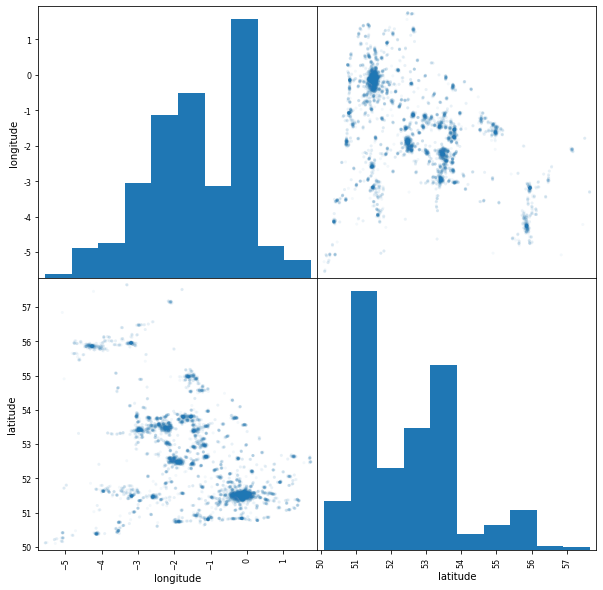

In [28]:
# матрица рассеяния и гистограммы
from pandas.plotting import scatter_matrix
scatter_matrix(data[columns], alpha=0.05, figsize=(10, 10));

In [29]:
# Проверить корелляции параметров
data[columns].corr()

,longitude,latitude
longitude,1.000000,-0.495708
latitude,-0.495708,1.000000


In [30]:
# Нормализуем значения (чтобы принимали одинаковый диапазон значений)
from sklearn import preprocessing
data_normalised = preprocessing.MinMaxScaler().fit_transform(data[columns].values)

In [31]:
# Вычислим Евклидово расстояние между каждым набором данных (нифига непонятно кста)
data_dist = pdist(data_normalised, 'euclidean')

# Иерархическая кластеризация!
# Собираем объекты в кластеры, используя подход снизу вверх (сначала каждый объект является отдельным кластером, пока не объединим все наблюдения в единый кластер) 
# и метрику слияния:
# average - среднее расстояние между всеми объектами между всевозможными парами кластеров
# single - среднее расстояние между ближайшими(!) парами кластеров
data_linkage = linkage(data_dist, method='average')

Используем метод локтя для определения оптимального количества кластеров для алгоритма K-means.


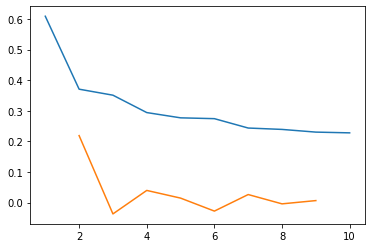

Рекомендованное количество кластеров: 2


In [32]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Рекомендованное количество кластеров:", k)

Установим кол-во кластеров для построения графиков и работы алгоритма k-means:

In [33]:
clusters_amount = 3

Построим дендограмму

In [34]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

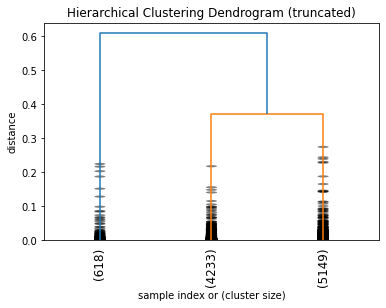

In [35]:
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=clusters_amount,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

Выведем массив с обозначением, в какой кластер попал каждый из объектов

In [37]:
clusters = fcluster(data_linkage, clusters_amount, criterion='maxclust')
clusters

array([3, 2, 2, ..., 2, 2, 3], dtype=int32)

Построим диаграмму

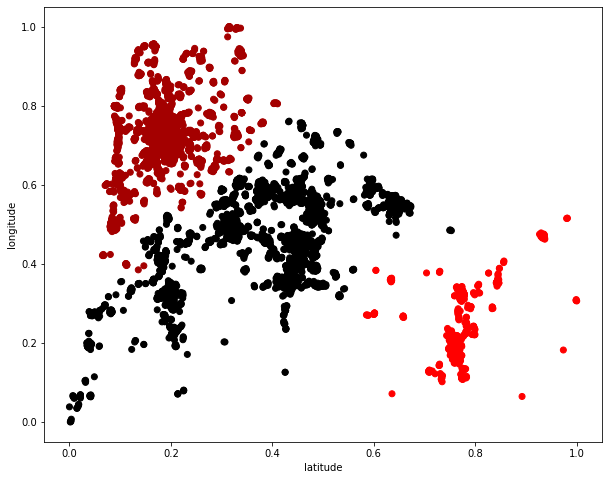

In [87]:
x = 1
y = 0
plt.figure(figsize=(10, 8))
plt.scatter(data_normalised[:,x], data_normalised[:,y], c=clusters, cmap='flag')
plt.xlabel(columns[x])
plt.ylabel(columns[y])
plt.show()

Выведем некоторую статистику по кластерам - кол-во объектов и средне значение параметра по кластеру

In [41]:
data['Agglomerative'] = clusters
result = data.groupby('Agglomerative')[columns].mean()
result['Amount'] = data.groupby('Agglomerative').size().values
result

,longitude,latitude,Amount
Agglomerative,,,
1,-3.739499,55.934799,618
2,-0.211647,51.505985,4233
3,-2.113504,53.021317,5149


Посмотреть содержание какого-нибудь конкретного кластера

In [44]:
cluster_num = 1
data[data['Agglomerative'] == cluster_num]

,longitude,latitude,Agglomerative
31345,-3.58182,54.5439,1
353604,-3.93776,56.0956,1
143055,-3.86843,55.7888,1
76541,-3.31699,57.6519,1
304563,-2.98196,56.4943,1
...,...,...,...
107255,-2.93572,54.8983,1
19871,-4.23831,55.8609,1
63415,-3.28816,55.9229,1
311828,-2.92396,56.4739,1



---
Теперь построим кластеризацию с помощью алгоритма Kmeans, а точнее его усовершенствованной версии k-means++ (начальные точки выбираются так, чтобы они находились как можно дальше друг от друга, а не случайным образом)


In [45]:
km = KMeans(n_clusters=clusters_amount, init='k-means++').fit(data_normalised)

In [46]:
# также выведем полученное распределение по кластерам - массив объектов с номером кластера, к которому он относится
km.labels_ +1

array([3, 1, 1, ..., 1, 1, 3], dtype=int32)

Построим диаграмму кластеров

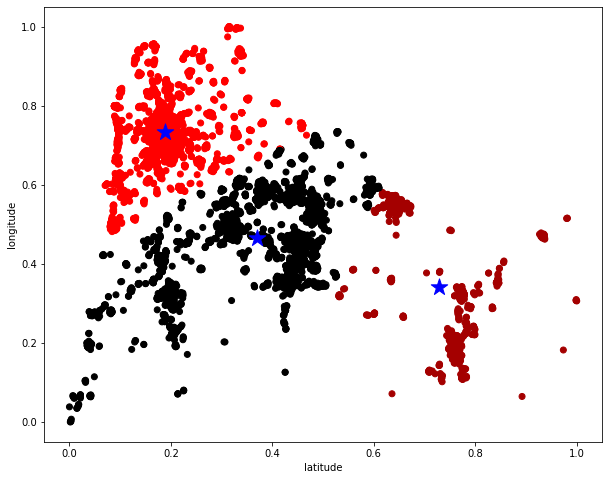

In [50]:
x = 1
y = 0
centroids = km.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(data_normalised[:,x], data_normalised[:,y], c=km.labels_, cmap='flag')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='b', label='centroid')
plt.xlabel(columns[x])
plt.ylabel(columns[y])
plt.show()

Статистика по кластерам:

In [51]:
data['KMeans'] = km.labels_+1
result = data.groupby('KMeans')[columns].mean()
result['Количество'] = data.groupby('KMeans').size().values
result

,longitude,latitude,Количество
KMeans,,,
1,-0.197027,51.530638,4252
2,-3.064853,55.605914,912
3,-2.162209,52.890496,4836


Посмотреть содержание какого-нибудь конкретного кластера

In [52]:
cluster_num = 3
data[data['KMeans'] == cluster_num]

,longitude,latitude,Agglomerative,KMeans
350694,-2.07264,51.9038,3,3
262337,-3.37818,51.7498,3,3
47912,-2.45655,50.6044,2,3
317208,-2.46217,53.7624,3,3
271456,-2.57648,51.5082,3,3
...,...,...,...,...
55223,-2.89761,53.2876,3,3
38082,-1.90675,53.2493,3,3
305442,-2.13710,52.4487,3,3
295390,-2.30977,51.4025,3,3


Сохранение результатов в файл

In [59]:
result_file = 'result/result_urbanGb.csv'
data.to_csv(result_file, index=False)


А теперь нарисуем кластеры на карте!!


In [68]:
result_file = 'result/result_urbanGb.csv'

geo_data = pd.read_csv(result_file)
geo_data.head()

,longitude,latitude,Agglomerative,KMeans
0,-2.072640,51.9038,3,3
1,0.665653,51.5629,2,1
2,-0.188842,51.9895,2,1
3,0.084454,51.5756,2,1
4,-3.378180,51.7498,3,3


Определим Bounding Box - область, определяющуюся 4 крайними значениями широты и долготы, таким образом область будет включать в себя все пространственные точки.

In [67]:
BBox = ((geo_data.longitude.min(), geo_data.longitude.max(), geo_data.latitude.min(), geo_data.latitude.max()))
print(BBox)

(-5.55473, 1.75302, 50.1009, 57.6519)


Заэкспортим изображение карты по координатам из Bounding Box с сайта https://www.openstreetmap.org/export.

In [64]:
map_image_file = 'result/map.png'
map_image = plt.imread(map_image_file)

Выберем, по какому методу кластеризации построить изображение: Means или Agglomerative

In [69]:
clusterization_algo = 'KMeans'

,longitude,latitude,Agglomerative,KMeans
0,-2.07264,51.9038,3,3
4,-3.37818,51.7498,3,3
6,-2.45655,50.6044,2,3
8,-2.46217,53.7624,3,3
9,-2.57648,51.5082,3,3
...,...,...,...,...
9993,-2.89761,53.2876,3,3
9994,-1.90675,53.2493,3,3
9995,-2.13710,52.4487,3,3
9996,-2.30977,51.4025,3,3


Построим изображение!

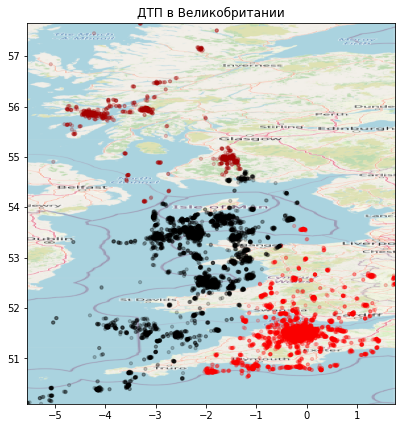

In [90]:
fig, ax = plt.subplots(figsize = (8,7))

geo_clusters = []
if clusterization_algo == 'KMeans':
    geo_clusters = km.labels_
else:
    geo_clusters = clusters

ax.scatter(geo_data.longitude, geo_data.latitude, zorder=1, alpha= 0.2, c=geo_clusters, cmap='flag', s=10)
ax.set_title('ДТП в Великобритании')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_image, zorder=0, extent = BBox, aspect= 'equal')